<a href="https://colab.research.google.com/github/revupnr/EVA8/blob/main/EVA_Assignment_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import Libraries

In [ ]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset
import random
import numpy as np
import matplotlib.pyplot as plt


import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

torch.set_printoptions(linewidth=120)

Check for GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

Custom Dataset Class

Each sample consists of an image, label of the image, a random number between 0 and 10 and the sum of random number and the image label. All are declared as torch.tensors for training on GPU

In [ ]:
img_train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform = transforms.Compose([
          transforms.ToTensor()
    ])
)


def get_number_feature(number,n_classes):
  arr = np.zeros([n_classes],dtype=np.int64)
  arr[number] = 1
  return torch.tensor(arr)
# Dataset is there to be able to interact with DataLoader

class MyDataset(Dataset):
  def __init__(self,img_set):
    self.data = img_set

  def __getitem__(self, index):
    image = torch.tensor(self.data[index][0])
    image_label = torch.tensor(self.data[index][1])

    randnum = random.randint(0,9)
    #random number input to be concatenated with the feature extracted from MNIST Image
    number_arr = torch.tensor(get_number_feature(randnum,n_classes=10))
    sum = torch.tensor((image_label+randnum))
    # print((image,image_label,number_arr,sum))
    return (image,image_label,number_arr,sum)

  def __len__(self):
    return len(self.data)


cuda:0
True


Create and Visualize a data sample

label: tensor(5)
random_number :  tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
sum: tensor(9)


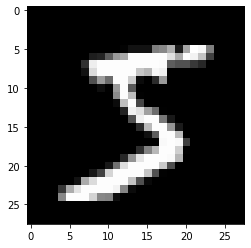

In [ ]:
train_set = MyDataset(img_train_set)
len(train_set)
sample = next(iter(train_set))
image, image_label,number,sum = sample
plt.imshow(image.squeeze(), cmap='gray')
print('label:', image_label)
print('random_number : ',number)
print('sum:',sum)

Create a visualize a batch

In [ ]:
#Create a batch of data
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = 32,
    shuffle=True
)

batch = next(iter(train_loader))
images, image_labels,number,sum = batch
images.shape, image_labels.shape,number.shape,sum.shape

labels: tensor([3, 1, 3, 6, 1, 3, 7, 0, 3, 4, 0, 8, 8, 4, 7, 4, 1, 4, 1, 7, 9, 2, 0, 3, 8, 6, 6, 3, 7, 8, 6, 7])


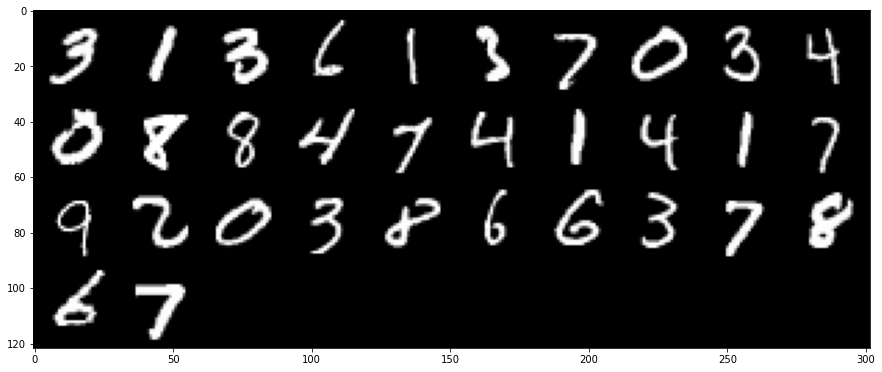

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', image_labels)

# Network Class

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    
    self.fc1 = nn.Linear(in_features=10+(12 * 4 * 4), out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60) 

    self.out_num = nn.Linear(in_features=60, out_features=10) #MNIST Value - number between 0-9,length = 10
    self.out_sum = nn.Linear(in_features=60, out_features=19) #SUM Value -number between 0-18,length = 19

  def forward(self, t1,t2): #t1 is the image, t2 is the one hot encoded random number
    # input layer
    x = t1

    # conv1 layer
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 28 | 24 | 12

    # conv2 layer
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) # 12 | 8 | 4 >> 12x4x4

    # reshape
    x = x.reshape(-1, 12 * 4 * 4) #Feature vector from the MNIST Image

    x_cat  = torch.cat((x,t2),dim=1) #concatenate feature vector from image with the one hot encoding of random number

    #Pass concatenated vector to the fully connected layers
    # fc1 layer
    x = self.fc1(x_cat)
    x = F.relu(x)

    # fc2 layer
    x = self.fc2(x)
    x = F.relu(x)

    # output layer
    # Generate two outputs from the FC layes, MNIST number and the sum
    out_num = self.out_num(x)
    out_sum = self.out_sum(x)

    out_num = F.softmax(out_num, dim=1)
    out_sum = F.softmax(out_sum, dim=1)
    return out_num,out_sum

Pass one sample to the network

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
sample = next(iter(train_set)) 
image, image_label,number,sum = sample

<ipython-input-84-4a162c056885>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.data[index][0])
<ipython-input-84-4a162c056885>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  number_arr = torch.tensor(get_number_feature(randnum,n_classes=10))
<ipython-input-84-4a162c056885>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sum = torch.tensor((image_label+randnum))


In [ ]:
network = Network()
print(image.shape,number.unsqueeze(dim=0).shape)
pred_num,pred_sum = network(image,number.unsqueeze(dim=0))
pred_num.argmax(dim=1)[0],pred_sum.argmax(dim=1)[0],image_label,sum

torch.Size([1, 28, 28]) torch.Size([1, 10])


(tensor(9), tensor(11), tensor(5), tensor(8))

In [ ]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

Create Optimizer 

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
torch.set_grad_enabled(True)

Pass one batch to the network

The network has two outputs - the mnist number and the sum. There are two losses - the number loss and the sum loss. The sum loss is considered for the back propogation

In [ ]:
batch = next(iter(train_loader))
images, image_labels,number,sum =batch

print(images.shape, image_labels.shape,number.shape,sum.shape )

#Loss before epoch
preds_num,preds_sum = network(images,number) # Pass Batch
loss_num = F.cross_entropy(preds_num, image_labels) # Calculate Loss
loss_sum = F.cross_entropy(preds_sum, sum) # Calculate Loss
loss = loss_sum
print('loss1:',loss)

optimizer.zero_grad()
loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

#Loss after epoch
preds_num,preds_sum = network(images,number) # Pass Batch
loss_num = F.cross_entropy(preds_num, image_labels) # Calculate Loss
loss_sum = F.cross_entropy(preds_sum, sum) # Calculate Loss
loss = loss_sum
print('loss2:',loss)

torch.Size([32, 1, 28, 28]) torch.Size([32]) torch.Size([32, 10]) torch.Size([32])
loss1: tensor(2.8699, grad_fn=<NllLossBackward0>)
loss2: tensor(2.8697, grad_fn=<NllLossBackward0>)


<ipython-input-84-4a162c056885>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.data[index][0])
<ipython-input-84-4a162c056885>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  number_arr = torch.tensor(get_number_feature(randnum,n_classes=10))
<ipython-input-84-4a162c056885>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sum = torch.tensor((image_label+randnum))


Train for few epochs

In [ ]:
for epoch in range(10):

    total_loss = 0
    total_loss_num = 0
    total_loss_sum = 0
    total_correct_num = 0
    total_correct_sum = 0

    for batch in train_loader: # Get Batch
        images, image_labels,number,sum =batch
        preds_num,preds_sum = network(images,number) # Pass Batch
        
        loss_num = F.cross_entropy(preds_num, image_labels) # Calculate Loss
        loss_sum = F.cross_entropy(preds_sum, sum) # Calculate Loss

        # loss = loss_num + loss_sum
        loss = loss_sum

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss_num += loss_num.item()
        total_loss_sum += loss_sum.item()

        total_loss += loss.item()
        total_correct_num += get_num_correct(preds_num, image_labels)
        total_correct_sum += get_num_correct(preds_sum, sum)

    print(
        "epoch", epoch, 
        "total_correct_num:", total_correct_num,
        "total_correct_sum:", total_correct_sum, 
        "total_loss_num:", total_loss_num,
        "total_loss_sum:", total_loss_sum
    )

<ipython-input-84-4a162c056885>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(self.data[index][0])
<ipython-input-84-4a162c056885>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  number_arr = torch.tensor(get_number_feature(randnum,n_classes=10))
<ipython-input-84-4a162c056885>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sum = torch.tensor((image_label+randnum))


epoch 0 total_correct_num: 6060 total_correct_sum: 6477 total_loss_num: 4317.1944262981415 total_loss_sum: 5432.728916883469
epoch 1 total_correct_num: 6174 total_correct_sum: 6444 total_loss_num: 4317.077878475189 total_loss_sum: 5433.013333082199
epoch 2 total_correct_num: 6027 total_correct_sum: 6454 total_loss_num: 4317.182626485825 total_loss_sum: 5433.47266292572
epoch 3 total_correct_num: 6137 total_correct_sum: 6500 total_loss_num: 4317.0216274261475 total_loss_sum: 5432.456401348114
epoch 4 total_correct_num: 6158 total_correct_sum: 6601 total_loss_num: 4317.062956809998 total_loss_sum: 5432.6592383384705
epoch 5 total_correct_num: 6159 total_correct_sum: 6557 total_loss_num: 4317.118715763092 total_loss_sum: 5432.453049659729
epoch 6 total_correct_num: 6075 total_correct_sum: 6501 total_loss_num: 4317.022060632706 total_loss_sum: 5432.347083091736
epoch 7 total_correct_num: 6082 total_correct_sum: 6625 total_loss_num: 4317.1261167526245 total_loss_sum: 5432.1619510650635
epoc

The loss is not decreasing.